In [21]:
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

seed(1)


# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
f = 10
N = 1000 * f
L = 20 * sqrt(f)
n0 = 0.005

locs = rand(N, 2) * L
#all_dist = squareform(pdist(locs))

# initial state
state = np.array(rand(N) < n0, dtype='int32')

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return  float(sum(int_state)) / N

n_real = density(state)
print("Real inital desity n_i = %.4f\n" % n_real)

def update(locs, state):
    panels = locs[state==1]
    for i, panel in enumerate(state):
        if panel == 2: # was created in last iteration
            state[i] = 1
        elif panel == 0:
            loc = np.asarray([locs[i]])
            dmin = np.min(distance.cdist(loc, panels))
            #dmin = np.min(all_dist[i][state == 1])
            scale = 0.05
            p = scale * np.exp(-dmin)
            r = rand()
            state[i] = 2 * int(p > r) # 2 if True, 0 else
            #if state[i] == 2: print(dmin, p, r, locs[i])
    print(sum(state==2))

    
def count_panels_at_fixed_distance(dmin, dmax, distance_matrix, state):
    #tol = 1. # km
    #if d < tol: raise Exception("Negative distance encountered.")
    #dmin = d - tol
    #dmax = d + tol

    #d_array = distance.cdist(np.asarray(p0), panels)[0]
    #helper = all_dist[state==1]
    #tot_count = np.sum(np.logical_and(helper < dmax, helper > dmin), axis=1)
    count = np.sum(np.logical_and(distance_matrix < dmax, distance_matrix > dmin), axis=1)
    return  float(np.mean(count)) / (dmin * dmin)


def count_panels_with_fixed_dmin(dmin, dmax, DM1, DM2):
    count = np.sum(np.logical_and(DM1 > dmin, DM1 < dmax), axis=1)
    tot_count = np.sum(np.logical_and(DM2 > dmin, DM2 < dmax), axis=1)
    return np.mean(count / tot_count)
    
    
# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 20 # MC steps

tol = 1e-3
radii = np.logspace(np.log10(L / sqrt(N)), np.log10(L / 6), 6, endpoint=True)
nr_fixed_distance = np.array([], dtype='float64')
nr_fixed_dmin = np.array([], dtype='float64')

tStart = time()
for step in range(n_steps):
    update(locs, state)
    n = density(state)
    densities.append(n)
    
    panels = locs[state==1]
    new_panels = locs[state==2]
    
    # evaluation 1
    # ----------------------------------------------------------------
    DM1 = distance.cdist(new_panels, panels)
    DM2 = distance.cdist(new_panels, locs)
    for k in range(len(radii) - 1):
        count = count_panels_with_fixed_dmin(radii[k], radii[k+1], DM1, DM2)
        nr_fixed_dmin = np.append(nr_fixed_dmin, [radii[k], count / sum(state==2)])
        
    # evaluation 2
    # ----------------------------------------------------------------
    distance_matrix = distance.cdist(panels, new_panels)
    for k in range(len(radii) - 1):
        count = count_panels_at_fixed_distance(radii[k], radii[k+1], distance_matrix, state)
        nr_fixed_distance = np.append(nr_fixed_distance, [radii[k], count / sum(state==2)])
        
    
elapsed = time() - tStart
print("Elapsed time %f" % elapsed)
n_final = density(state)
print("Real final density n = %.4f\n" % n_final)

Real inital desity n_i = 0.0046

23
31
35
43
59


<ipython-input-21-7ca4d28f7e89>:72: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(count / tot_count)


52
68
65
91
76
102
90
86
114
100
123
122
140
124
127
Elapsed time 11.788954
Real final density n = 0.1844



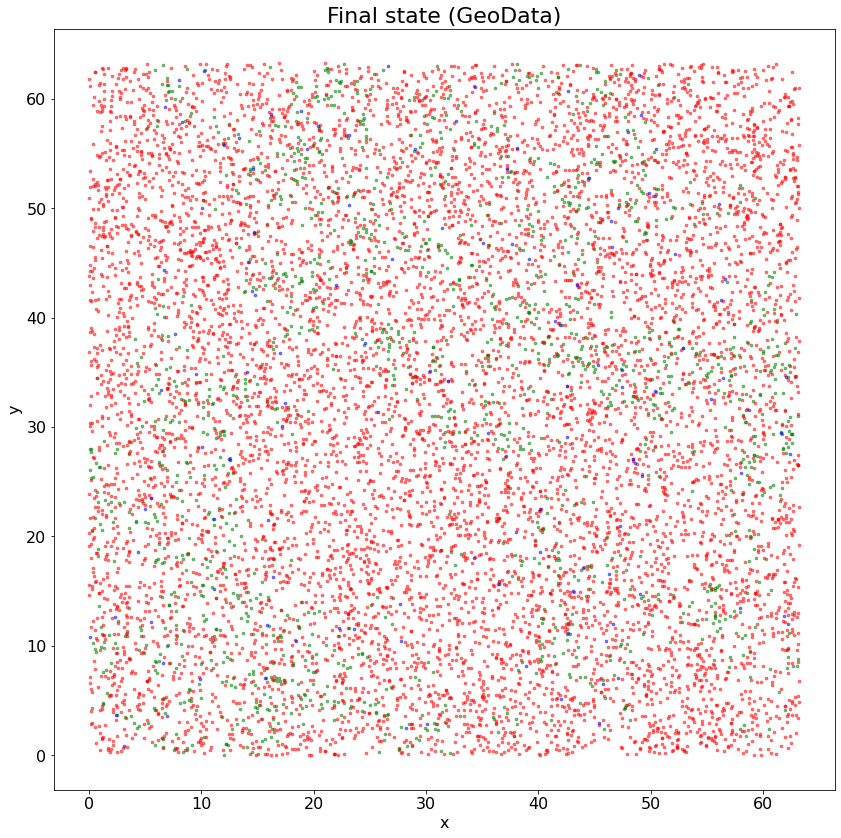

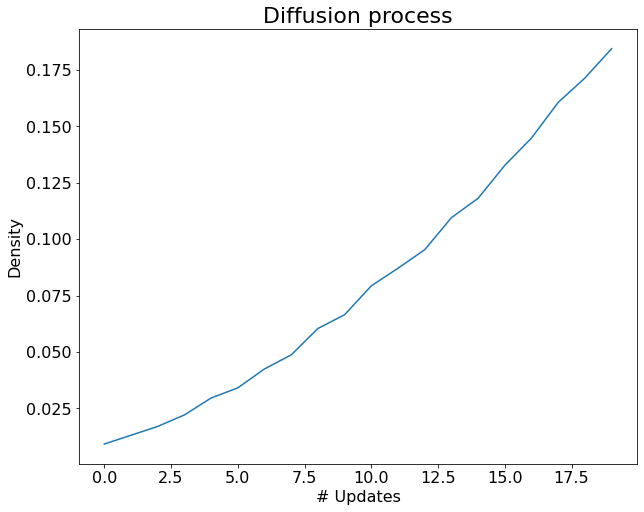

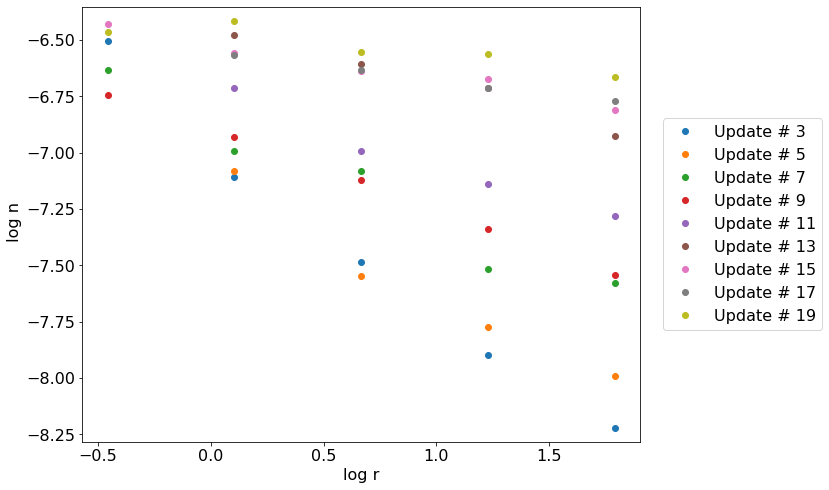

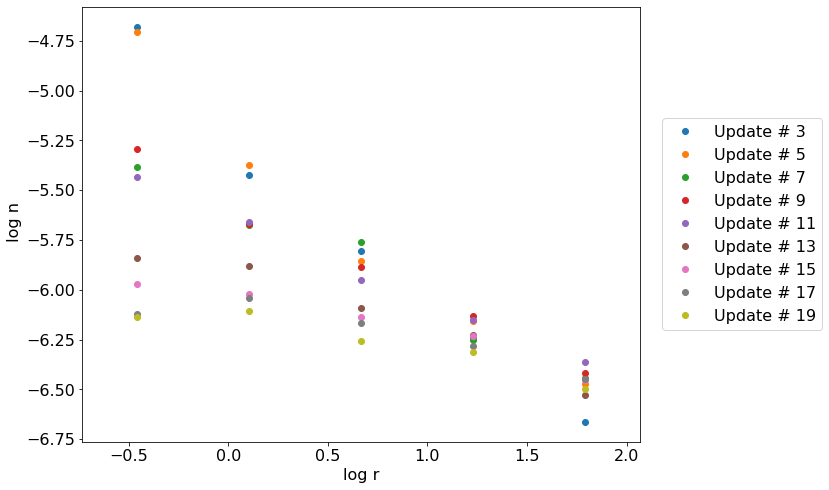

In [23]:
# add figure
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)

panels = locs[state == 1]
empty = locs[state == 0]
new = locs[state == 2]

ax.scatter(panels[:,0], panels[:,1], color='green', s=7, alpha=0.5)
ax.scatter(empty[:,0], empty[:,1], color='red', s=7, alpha=0.5)
ax.scatter(new[:,0], new[:,1], color='blue', s=7, alpha=0.5)
plt.title("Final state (GeoData)", size=22)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
        
# diffusion proces
fig = plt.figure(figsize=(10, 8))
plt.plot(densities)
plt.title("Diffusion process", size=22)
plt.xlabel("# Updates")
plt.ylabel("Density")
plt.show()

fig = plt.figure(figsize=(10, 8))
ndata = nr_fixed_dmin.reshape((int(nr_fixed_dmin.shape[0] / (2 * 5)), 5, 2))
#data = np.log(data)
for k, update in enumerate(ndata[2::2], start=0):
    plt.plot(np.log(update[:, 0]), np.log(update[:, 1]), 'o', label="Update # %d" % (2*k+3))
plt.axis('equal')
plt.ylabel(" log n")
plt.xlabel("log r")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

fig = plt.figure(figsize=(10, 8))
ndata = nr_fixed_distance.reshape((int(nr_fixed_distance.shape[0] / (2 * 5)), 5, 2))
#data = np.log(data)
for k, update in enumerate(ndata[2::2], start=0):
    plt.plot(np.log(update[:, 0]), np.log(update[:, 1]), 'o', label="Update # %d" % (2*k+3))
plt.axis('equal')
plt.ylabel(" log n")
plt.xlabel("log r")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

In [111]:
# For a more detailed analysis
# one will look at similar simulations with greater data sets

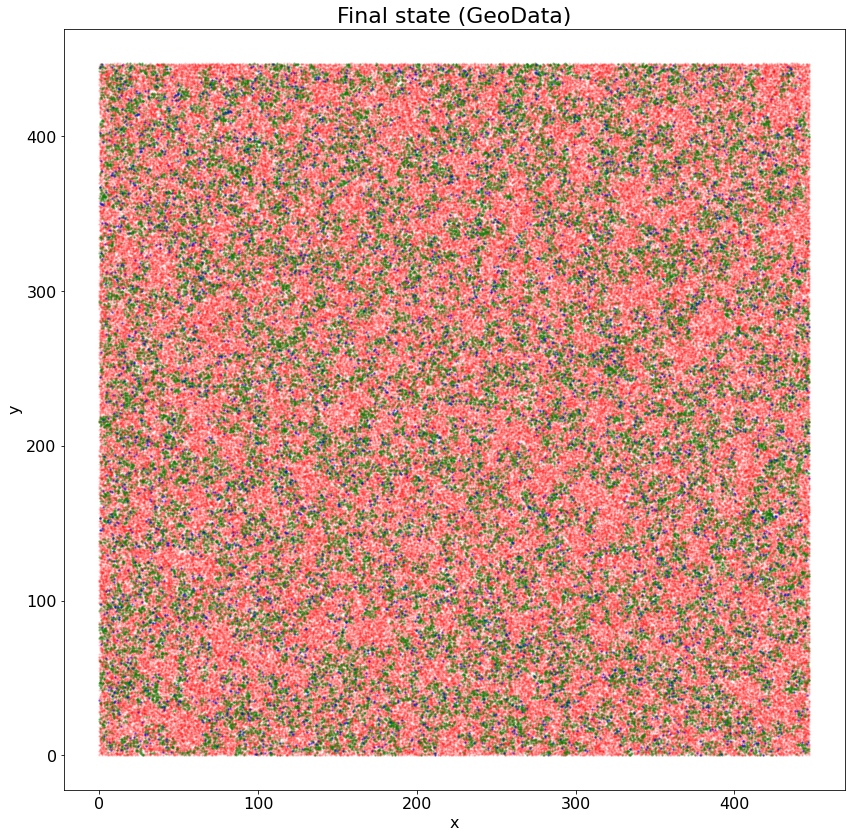

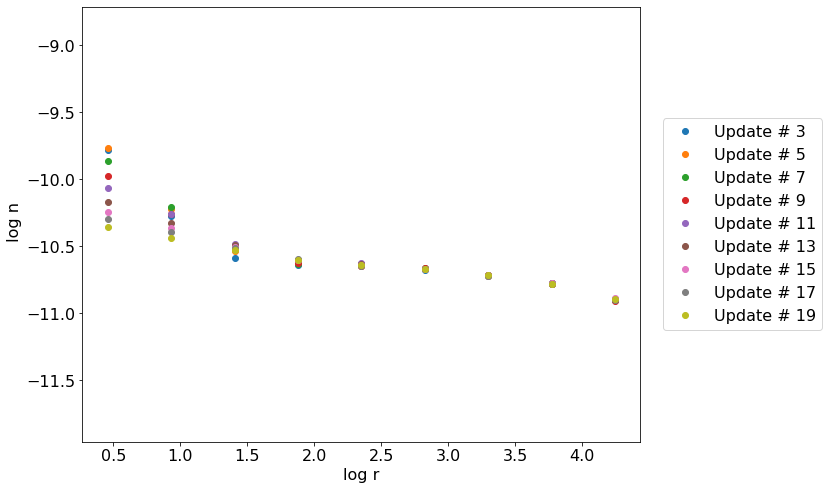

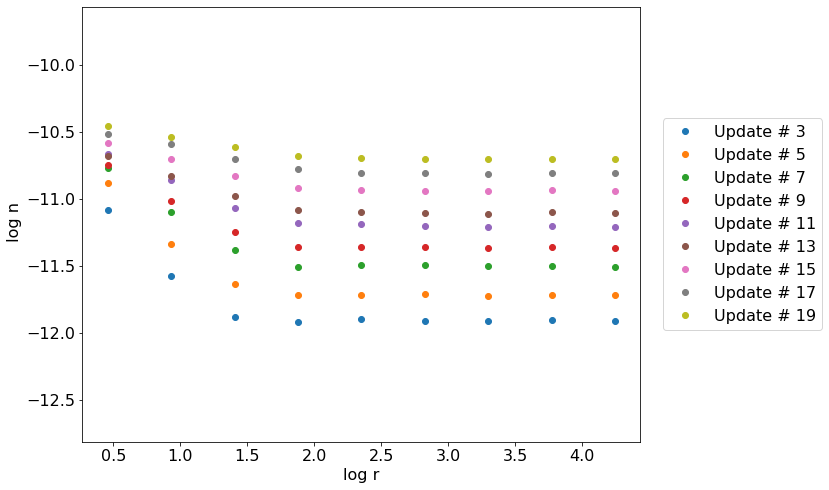

In [112]:
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

# load data
fState = "data/pop_state.csv"
fLocs = "data/pop_locs.csv"
fData1 = "data/pop_data_eval1.csv"
fData2 = "data/pop_data_eval2.csv"

state = np.loadtxt(fState)
locs = np.loadtxt(fLocs)
data1 = np.loadtxt(fData1)
data2 = np.loadtxt(fData2)

# add figure
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)

panels = locs[state == 1]
empty = locs[state == 0]
new = locs[state == 2]

ax.scatter(empty[:,0], empty[:,1], color='red', s=2, alpha=0.1)
ax.scatter(panels[:,0], panels[:,1], color='green', s=2, alpha=0.3)
ax.scatter(new[:,0], new[:,1], color='blue', s=2, alpha=0.4)
plt.title("Final state (GeoData)", size=22)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# diffusion proces
# fig = plt.figure(figsize=(10, 8))
# plt.plot(densities)
# plt.title("Diffusion process", size=22)
# plt.xlabel("# Updates")
# plt.ylabel("Density")
# plt.show()

fig = plt.figure(figsize=(10, 8))
ndata = data1.reshape((int(data1.shape[0] / (2 * 9)), 9, 2))
#data = np.log(data)
for k, update in enumerate(ndata[2::2], start=0):
    plt.plot(np.log(update[:, 0]), np.log(update[:, 1]), 'o', label="Update # %d" % (2*k+3))
plt.axis('equal')
plt.ylabel(" log n")
plt.xlabel("log r")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

fig = plt.figure(figsize=(10, 8))
ndata = data2.reshape((int(data2.shape[0] / (2 * 9)), 9, 2))
#data = np.log(data)
for k, update in enumerate(ndata[2::2], start=0):
    plt.plot(np.log(update[:, 0]), np.log(update[:, 1]), 'o', label="Update # %d" % (2*k+3))
plt.axis('equal')
plt.ylabel(" log n")
plt.xlabel("log r")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()


In [113]:
# Final density of the state
print("Final Density:")
print(np.sum(state >=1) / 500000)

Final Density:
0.140544


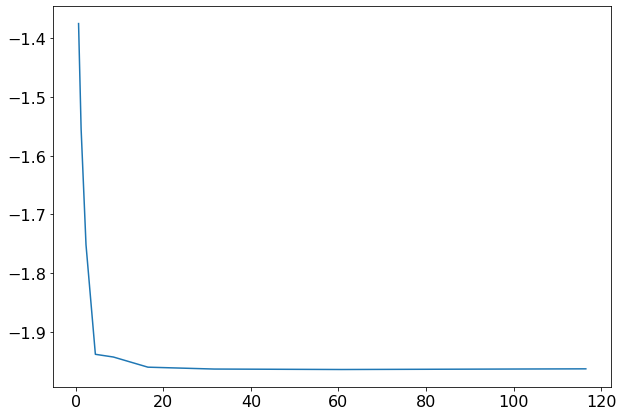

In [165]:
# Analyse the value of the state
#--------------------------------
# Pick m random points
cidx = np.random.choice(np.arange(0, N, 1)[state>=1], 400)
centers = locs[cidx]
# calculate distance to panels
dists = distance.cdist(centers, locs[state>=1])
distsAll = distance.cdist(centers, locs)
N = state.size
L = 20 * sqrt(N / 1000)
r = np.logspace(np.log10(L / sqrt(N)), np.log10(L / 2), 10, endpoint=True)

prob = [np.mean(np.sum(np.logical_and(dists<riu, dists>ril), axis=1) / np.sum(np.logical_and(distsAll<riu, distsAll>ril), axis=1)) for ril, riu in zip(r[:-1], r[1:])]

plt.figure(figsize=(10, 7))
plt.plot(r[:-1], np.log(prob))
plt.show()

#  free Mem
dists = []
distsAll = []

In [168]:
# free Mem
state = []
locs = []

======= Scale : 63.24555320336759
======= Scale : 31.622776601683796
======= Scale : 15.811388300841898
======= Scale : 7.905694150420949
======= Scale : 3.9528470752104745
======= Scale : 1.9764235376052373
======= Scale : 0.9882117688026186
======= Scale : 0.4941058844013093
======= Scale : 0.24705294220065466
The Hausdorff dimension is 1.9999999999999993


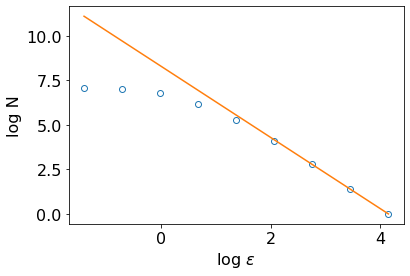

In [36]:
# computing the fractal dimension
#considering only scales in a logarithmic list
import numpy as np

data = locs[np.logical_or(state==1, state==2)]
Lx = L
Ly = L
scales=L * 1./2**(np.arange(0, 9, 1))
Ns=[]
# looping over several scales
for scale in scales:
    print ("======= Scale :",scale)
    # computing the histogram
    H, edges=np.histogramdd(data, bins=(np.arange(0,Lx+scale/2,scale),np.arange(0,Ly+scale/2,scale)))
    Ns.append(np.sum(H>0))

eps = scales
# linear fit, polynomial of degree 1
coeffs=np.polyfit(np.log(eps)[:2], np.log(Ns)[:2], 1)
 
plt.plot(np.log(eps),np.log(Ns), 'o', mfc='none')
plt.plot(np.log(eps), np.polyval(coeffs,np.log(eps)))
plt.xlabel('log $\epsilon$')
plt.ylabel('log N')
 
print ("The Hausdorff dimension is", -coeffs[0]) #the fractal dimension is the OPPOSITE of the fitting coefficient

In [103]:
# How does r^2 approximate N(A_r)
# with different scaling of N?
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

tStart = time()
fdata = []
for f in range(30, 200, 20):
    
    seed(1)

    N = 1000 * f
    L = 20 * sqrt(f)
    n0 = 0.005

    locs = rand(N, 2) * L
    idx = np.random.randint(0, N, 100)
    
    all_dist = distance.cdist(locs[idx], locs)
    
    tol = 1e-3
    radii = np.logspace(np.log10(L / sqrt(N)), np.log10(L / 6), 6, endpoint=True)
    
    data = []
    # evaluation
    # ----------------------------------------------------------------
    for r in radii:
        n = np.mean(np.sum((all_dist < r), axis=1))
        data.append([r/L, n / (r/L * r/L)])
    
    fdata.append(data)
    
elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

Elapsed time 1.704751


In [71]:
fdata

[[[0.6324555320336759, 75.94999999999999],
  [0.8818602062217206, 39.065040451354534],
  [1.2296159712869854, 20.0931847987619],
  [1.7145069322516806, 10.334971388547409],
  [2.3906114505510097, 5.315814027086192],
  [3.333333333333334, 2.734199999999999]],
 [[0.6324555320336759, 75.94999999999999],
  [0.8818602062217206, 39.065040451354534],
  [1.2296159712869854, 20.0931847987619],
  [1.7145069322516806, 10.334971388547409],
  [2.3906114505510097, 5.315814027086192],
  [3.333333333333334, 2.734199999999999]]]

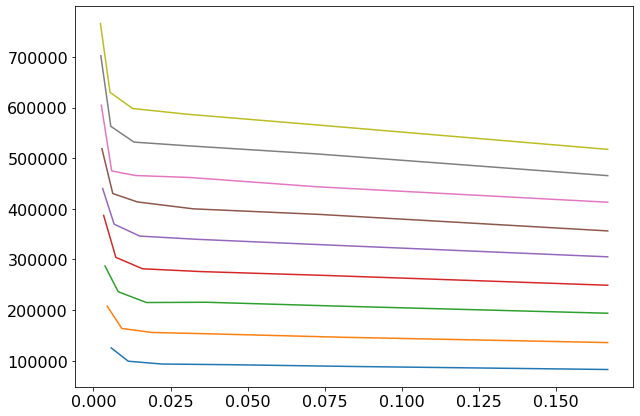

In [104]:
plt.figure(figsize=(10, 7))
for data in fdata[:]:
    data = np.asarray(data)
    plt.plot(data[:, 0], data[:, 1])
plt.show()

In [111]:
locs.shape

(190000, 2)

In [175]:
distance.cdist([[1, 2]], [[1, 4], [1, 2]])

array([[2., 0.]])

In [174]:
np.asarray([np.asarray([0, 1])])

array([[0, 1]])